[![Colab Badge Link](https://img.shields.io/badge/open-in%20colab-blue)](https://colab.research.google.com/github/Glasgow-AI4BioMed/tutorials/blob/main/twohop_link_prediction.ipynb)

# Two-Hop Link Prediction for a Knowledge Graph

As a starting place for rule-based link prediction, let's look at two-hop relations that can be used to predict a single relation. The diagram below shows an example of this:

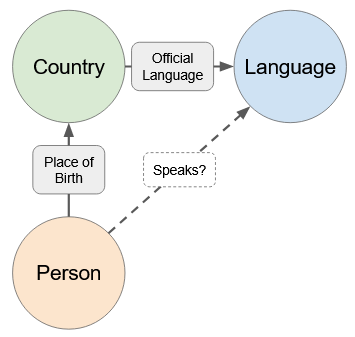

In this case, a person that it is born in a country is likely to speak its official language. Here the two hops are "Place of Birth" and "Official Language". These two hops would be the body of a rule and the head would be the "Speaks" relation.

This can be written as a rule (similar to those in the AnyBURL paper) with the head on the left and the body on the right.

$ speaks(P,L) \leftarrow placeOfBirth(P,C) \text{ & }  officialLanguage(C,L) $

This Colab will look at applying a rule and finding more two-hop rules. Notably, AnyBURL goes beyond 2-hop rules to longer rules.

## Prerequisites

We'll first install the Pykeen library as it is useful for loading in other datasets.

In [1]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Loading the knowledge graph

We'll use the [Codex knowledge graph](https://github.com/tsafavi/codex) because it's more interesting to look at than FB15k-237 or WN18RR. It contains knowledge from Wikipedia and WikiData.



In [2]:
from pykeen.datasets import CoDExSmall

dataset = CoDExSmall()

INFO:pykeen.utils:Using opt_einsum


We can then pull out the training, validation and test triples from the knowledge graph. This also shows the number of each data split.

In [3]:
train_triples = dataset.training.mapped_triples.numpy()
val_triples = dataset.validation.mapped_triples.numpy()
test_triples = dataset.testing.mapped_triples.numpy()

train_triples.shape,val_triples.shape,test_triples.shape

((32888, 3), (1827, 3), (1828, 3))

If you look at the triples, they contain indices. While we can process this graph without knowing what it means, it'd be nice to know the entity and relation mappings so we can look at things.

In [4]:
print(train_triples[:10])

[[   1   23  263]
 [   1   28  264]
 [   1   31  222]
 [   1   31  452]
 [   1   31  576]
 [   1   31  646]
 [   1   31 1002]
 [   1   31 1126]
 [   1   31 1144]
 [   1   31 1247]]


To make it easier to understand, we'll download the actual text mappings for the entities and relations (instead of just having to look at the node and edge indices).

In [5]:
!wget -O codex_entities.json https://github.com/tsafavi/codex/raw/master/data/entities/en/entities.json
!wget -O codex_relations.json https://raw.githubusercontent.com/tsafavi/codex/master/data/relations/en/relations.json

--2025-07-12 20:07:33--  https://github.com/tsafavi/codex/raw/master/data/entities/en/entities.json
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tsafavi/codex/master/data/entities/en/entities.json [following]
--2025-07-12 20:07:34--  https://raw.githubusercontent.com/tsafavi/codex/master/data/entities/en/entities.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10498709 (10M) [text/plain]
Saving to: ‘codex_entities.json’

codex_entities.json 100%[===================>]  10.01M  --.-KB/s    in 0.1s    

2025-07-12 20:07:34 (102 MB/s) - ‘codex_entities.json’ saved [10498709/10498709]

--2025

And then we load the entities and create mappings `entityindex_to_name` and `relindex_to_name` from knowledge graph indices to names.

In [6]:
import json
with open('codex_entities.json') as f:
  codex_entities = json.load(f)
with open('codex_relations.json') as f:
  codex_relations = json.load(f)

# Create a mapping from the knowledge base identifiers to the entity/relation names
entityid_to_name = { entityid:codex_entities[entityid]['label'] for entityid in codex_entities }
relid_to_name = { relid:codex_relations[relid]['label'] for relid in codex_relations }

# Going through the KB identifiers, create a mapping directly from the indices to the names
entityindex_to_name = { entityindex:entityid_to_name[entityid] for entityid,entityindex in dataset.entity_to_id.items() }
relindex_to_name = {relindex:relid_to_name[relid] for relid,relindex in dataset.relation_to_id.items() }


It'll be useful to have a backwards mapping from name to index too.

In [7]:
entityname_to_index = { name:index for index,name in entityindex_to_name.items() }
relname_to_index = { name:index for index,name in relindex_to_name.items() }

We need to know the unique entity and relation indices and their count.

In [8]:
entityindices = sorted(entityindex_to_name.keys())
relindices = sorted(relindex_to_name.keys())

print(f"Number of entities = {len(entityindices)}")
print(f"Number of relations = {len(relindices)}")

Number of entities = 2034
Number of relations = 42


We can show a small sample of the mappings for entities

In [9]:
for entityindex in range(10):
  print(f"{entityindex}\t{entityindex_to_name[entityindex]}")

0	Boston
1	Gabon
2	Mohandas Karamchand Gandhi
3	Gambia
4	Guinea
5	Guinea-Bissau
6	Ivory Coast
7	Cameroon
8	Fred Astaire
9	Giorgio Gaber


And here are the relation indices with names.

In [10]:
for relindex,name in relindex_to_name.items():
  print(f"{relindex}\t{name}")

0	field of work
1	member of political party
2	medical condition
3	occupation
4	employer
5	founded by
6	place of burial
7	instrument
8	movement
9	genre
10	named after
11	religion
12	languages spoken, written, or signed
13	headquarters location
14	cast member
15	country
16	ethnic group
17	place of birth
18	place of death
19	time period
20	spouse
21	record label
22	country of citizenship
23	continent
24	practiced by
25	sibling
26	head of state
27	part of
28	official language
29	child
30	unmarried partner
31	member of
32	country of origin
33	cause of death
34	diplomatic relation
35	residence
36	educated at
37	influenced by
38	location of formation
39	parent organization
40	notable works
41	narrative location


And now we can use the mappings to look at what is in the knowledge graph. Below are a few triples with the indices mapped to names of entities and relations.

In [11]:
for head,rel,tail in train_triples[:10]:
  head_name = entityindex_to_name[head]
  rel_name = relindex_to_name[rel]
  tail_name = entityindex_to_name[tail]

  print(f"{head_name}\t{rel_name}\t{tail_name}")

Gabon	continent	Africa
Gabon	official language	French
Gabon	member of	Organisation internationale de la Francophonie
Gabon	member of	Universal Postal Union
Gabon	member of	International Bank for Reconstruction and Development
Gabon	member of	OHADA
Gabon	member of	"African, Caribbean and Pacific Group of States"
Gabon	member of	AFRISTAT
Gabon	member of	African Development Bank
Gabon	member of	International Telecommunication Union


## Indexing the knowledge graph

Before we can get stuck into checking/finding rules, we want to index the knowledge base. This makes it faster to get the list of relations for an entity.

These knowledge graphs treat all relations as directional. For example (e1, 'named_after', e2) is different from (e2, 'named_after', e1). So when we store the neighbours of an entity, we want to know if the relation is outgoing from the entity or incoming to the entity. We'll store each relation as a tuple with the relation index plus a boolean of whether it is outgoing or incoming. We'll use a [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to store relations indexed by the entity they originate from.



In [12]:
from collections import defaultdict

neighbours = defaultdict(list)

for head,rel,tail in train_triples:
  outgoing_rel = (rel,True)
  incoming_rel = (rel,False)

  neighbours[head].append( (outgoing_rel,tail) )
  neighbours[tail].append( (incoming_rel,head) )

Now we can quickly look up outgoing and incoming relations from an entity. Let's do that for an entity. Index 8 is Fred Astaire.

In [13]:
entityindex = 8
print("Showing relations for entity:", entityindex_to_name[entityindex])

neighbours_for_this_entity = sorted(neighbours[entityindex])
for (relindex,is_outgoing), neighbour_entityindex in neighbours_for_this_entity:
  # Add a ~ if it is an incoming relation
  relname = relindex_to_name[relindex] if is_outgoing else '~'+relindex_to_name[relindex]
  print(" -", relname, "-", entityindex_to_name[neighbour_entityindex])

Showing relations for entity: Fred Astaire
 - member of political party - Republican Party
 - occupation - television actor
 - occupation - film actor
 - occupation - stage actor
 - occupation - voice actor
 - occupation - choreographer
 - occupation - screenwriter
 - occupation - film producer
 - occupation - actor
 - occupation - dancer
 - occupation - musician
 - occupation - television presenter
 - instrument - voice
 - genre - traditional pop music
 - languages spoken, written, or signed - English
 - ethnic group - Jewish people
 - place of death - Los Angeles
 - time period - 20th century
 - country of citizenship - United States of America
 - cause of death - pneumonia
 - ~influenced by - Michael Jackson


Most of the relations are outgoing from Fred Astaire, e.g. he is an actor. But one is incoming (marked by the tilde mark here), that Michael Jackson was influenced by him.

## Testing a rule

Let's test the rule from the beginning:

$ speaks(P,L) \leftarrow placeOfBirth(P,C) \text{ & }  officialLanguage(C,L) $

We'll create some variables to represent the body and head of our rule. We've matched them to the relation names used in the Codex knowledge base (which were output earlier).

In [14]:
candidate_body = ('place of birth', 'official language')
candidate_head = 'languages spoken, written, or signed'

Then we need to transform the text names to the indices for the relations.

In [15]:
candidate_body_rels = ( (relname_to_index[candidate_body[0]],True), (relname_to_index[candidate_body[1]],True) )
candidate_head_rel = (relname_to_index[candidate_head],True)

print("candidate_body_rels =",candidate_body_rels)
print("candidate_head_index =",candidate_head_rel)

candidate_body_rels = ((17, True), (28, True))
candidate_head_index = (12, True)


Now we're going to iterate through every two-hop found in the knowledge graph. This is not very efficient and would be a bad idea for large knowledge graphs. For every two-hop, we'll check if it matches the body ("place of birth", "official language"). And if it does, we'll see if the head relation ("languages spoken, written, or signed") exists between the two entities at the end of the two-hop relation.

In [16]:
head_count, body_count = 0,0

# Go through all the entities
for e1 in entityindices:
  e1_neighbours = neighbours[e1]

  # Iterate through each neighbor of e1
  for rel1,e2 in e1_neighbours:
    # Iterate through each neighbor of e2
    for rel2,e3 in neighbours[e2]:
      # Skip any hops that contain cycles
      if e1 == e2 or e1 == e3:
        continue

      # Check if this two hop matches our candidate body
      if (rel1,rel2) == candidate_body_rels:
        e1_name = entityindex_to_name[e1]
        e2_name = entityindex_to_name[e2]
        e3_name = entityindex_to_name[e3]

        # Check if the candidate head exists between e1 and e3
        head_found = ((candidate_head_rel,e3) in e1_neighbours)

        body_count += 1
        if head_found:
          head_count += 1

        print(f"{head_found}\t{e1_name}\t{e2_name}\t{e3_name}")

True	Vitaly Ginzburg	Moscow	Russian
True	Nyusha	Moscow	Russian
True	George Soros	Budapest	Hungarian
False	George Tabori	Budapest	Hungarian
False	Leó Szilárd	Budapest	Hungarian
True	Albert Lortzing	Berlin	German
False	Toni Braxton	Atlanta	English
False	Dennis Gabor	Budapest	Hungarian
True	Roman Jakobson	Moscow	Russian
False	Kanye West	Atlanta	English
False	Theodore von Kármán	Budapest	Hungarian
False	Rodion Shchedrin	Moscow	Russian
True	John von Neumann	Budapest	Hungarian
True	Albert Szent-Györgyi	Budapest	Hungarian
True	Veniamin Smekhov	Moscow	Russian
False	Kelly Rowland	Atlanta	English
True	Sofia Kovalevskaya	Moscow	Russian
False	Raven-Symoné	Atlanta	English
True	Andrey Korotayev	Moscow	Russian
True	Ivan Andreyevich Krylov	Moscow	Russian
True	Anatoly Krupnov	Moscow	Russian
True	Alexander Ivanovich Herzen	Moscow	Russian
False	Sergey Mikhalkov	Moscow	Russian
False	T.I.	Atlanta	English
True	Julia Volkova	Moscow	Russian
False	Regina Spektor	Moscow	Russian
True	China Anne McClain	Atlanta	E

Now we can see all the people, their place of birth and the language of their place of birth. The first column shows whether there is a "languages spoken, written, or signed" relation between the person and the language.

Most of them show that the proposed rule (below) holds.

$ speaks(P,L) \leftarrow placeOfBirth(P,C) \text{ & }  officialLanguage(C,L) $

Some of the falses look like mistakes. Kanye West does speak English so that's a missing relation. So it looks like this rule may be useful. We can estimate it using the number of Trues/Falses from above. We stored them and can calculate below:

In [17]:
rule_confidence = head_count / body_count
rule_confidence

0.639344262295082

Pretty good. And many of the negatives are likely missing edges. In the next section, we'll try to find more two-hop rules.

## Make some rules

We want to generate some candidate rules where the body is a two-hop relation.

Let's find every two-hop relation in the knowledge graph (from e1, to e2 and on to e3). And let's count them. These two-hop relations would be considered the body of rules.

And as we do that, we'll also count how many single-hops go from the same start entity (e1) directly to the final entity (e3). This single relation would be considered the heads of rules.

We want to find rules with a body (two-hop relation) that predicts a head (single relation).

In [18]:
from tqdm.auto import tqdm
from collections import Counter

twohops_body_counts = Counter()
twohops_head_counts = defaultdict(Counter)

# Go through all the entities
for e1 in tqdm(entityindices):
  e1_neighbours = neighbours[e1]

  # Iterate through each neighbor of e1
  for rel1,e2 in e1_neighbours:
    # Iterate through each neighbor of e2
    for rel2,e3 in neighbours[e2]:
      # Skip any hops that contain cycles
      if e1 == e2 or e1 == e3:
        continue

      # Count the two-hop relations that got us from e1 to e3.
      twohops_body_counts[(rel1,rel2)] += 1

      # Count the single relations that got us from e1 to e3.
      e1_e3_rels = [ rel for rel,e in e1_neighbours if e == e3 ]
      twohops_head_counts[(rel1,rel2)] += Counter(set(e1_e3_rels))

  0%|          | 0/2034 [00:00<?, ?it/s]

Now we can go through the head and body counts and calculate for each body, how many times a head occurs. And then we can divide one by the other to get a proportion of times the rule holds with our current data.

We'll use an idea from the AnyBURL paper and do some "pseudo laplacian smoothing" by adding a factor to the denominator. This is nice because it effectively downweights rules with very small numbers of head/body counts, and barely affects strongly supported rules.

In [19]:
# We'll add this to the denominator
pseudo_laplacian_smoothing_factor = 2

results = []
for body,body_count in twohops_body_counts.items():
  rel1,rel2 = body

  candidate_head_counts = twohops_head_counts[body]

  for head_rel,head_count in candidate_head_counts.items():
    rule_confidence = head_count/(body_count+pseudo_laplacian_smoothing_factor)

    results.append( (rule_confidence,body,head_rel,body_count,head_count) )

Now let's print out some of our candidate rules with their confidence scores. There are many about children and siblings, for example that person X's child's sibling is also person X's child.

In [20]:
results = sorted(results,reverse=True)
for result in results[:200]:
  rule_confidence,body,head_rel,body_count,head_count = result

  candidate_head = relindex_to_name[head_rel[0]] if head_rel[1] else '~'+relindex_to_name[head_rel[0]]

  rel1,rel2 = body
  rel1_name = relindex_to_name[rel1[0]] if rel1[1] else '~'+relindex_to_name[rel1[0]]
  rel2_name = relindex_to_name[rel2[0]] if rel2[1] else '~'+relindex_to_name[rel2[0]]

  candidate_body = (rel1_name, rel2_name)

  print(f"{rule_confidence:.3f}\t{candidate_head} <- {candidate_body}")

0.971	child <- ('child', '~sibling')
0.971	~child <- ('sibling', '~child')
0.958	child <- ('child', 'sibling')
0.958	~child <- ('~sibling', '~child')
0.872	sibling <- ('~child', 'child')
0.872	~sibling <- ('~child', 'child')
0.868	~sibling <- ('sibling', 'sibling')
0.868	sibling <- ('~sibling', '~sibling')
0.864	sibling <- ('sibling', '~sibling')
0.864	~sibling <- ('sibling', '~sibling')
0.864	sibling <- ('~sibling', 'sibling')
0.864	~sibling <- ('~sibling', 'sibling')
0.861	sibling <- ('sibling', 'sibling')
0.861	~sibling <- ('~sibling', '~sibling')
0.833	ethnic group <- ('child', 'ethnic group')
0.833	~ethnic group <- ('~ethnic group', '~child')
0.826	languages spoken, written, or signed <- ('member of', 'languages spoken, written, or signed')
0.826	languages spoken, written, or signed <- ('member of', 'field of work')
0.826	~languages spoken, written, or signed <- ('~languages spoken, written, or signed', '~member of')
0.826	~languages spoken, written, or signed <- ('~field of work'

You could then use these candidate rules to make predictions on missing edges in the graph.